In [ ]:
def bet_positive_max(runners, bet_chunk):
    """bet max given prob>scale"""

    diffs = [(r['probability'] - r['odds_scale'], r) for r in runners]
    diffs.sort(key=itemgetter(0), reverse=True)

    ##############################################################################################
    # -1% roi 42% wr 100% races
    ##############################################################################################
#     num_bets = math.ceil(len(runners) * 0.125)


    ##############################################################################################
    # -2% roi 29% wr 100% races
    ##############################################################################################
    num_bets = 1


    ##############################################################################################
    # 10% roi 35% wr 33% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 8:
#         return [], 0

    
    ##############################################################################################
    # -3% roi 31% wr 77% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 12:
#         return [], 0

    
    ##############################################################################################
    # 0% roi 53% wr 33% races
    ##############################################################################################
#     num_bets = 2
#     if len(runners) > 8:
#         return [], 0

    total_probs = sum(d[1]['probability'] for d in diffs[:num_bets])
    for d, r in diffs[:num_bets]:
        r['bet'] = bet_chunk * r['probability'] / total_probs

    runners = [d[1] for d in diffs]
    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_max)

In [95]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))

12813 races loaded!


In [97]:
category = 'H'
dfo = dfo.loc[dfo['race_type'].isin([category])]
print('{} {} races!'.format(len(dfo), category))

3364 H races!


In [98]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,3364.000000,3364.000000,3364.000000,3364.000000
mean,7110.684007,5.129905,1942.183710,9.470868
std,3816.199097,2.891755,388.334557,2.420312
min,19.000000,1.000000,1119.000000,4.000000
25%,4000.750000,3.000000,1609.000000,8.000000
50%,7194.500000,5.000000,1755.000000,9.000000
75%,10466.250000,7.000000,2175.000000,11.000000
max,13467.000000,12.000000,3309.000000,20.000000


In [99]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [100]:
def process_strategy(dfp, strategy, x):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in dfp.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['odds_win']]
        if not runners:
            continue
    
        # default 0 bets
        for runner in runners:
            runner['bet'] = 0
        
        runners, num_bets = strategy(runners, bet_chunk, x)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])
            
    book_df = pd.DataFrame(book)
    return book_df

In [101]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    win_diff = 0
    max_diff = 0
    prob2scales = []
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if runner['bet']:
            prob2scales.append(runner['probability'] / runner['odds_scale'])
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                # odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                odds = runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['prob2scale_avg'] = sum(prob2scales) / len(prob2scales)
    outcome['prob2scale'] = min(prob2scales)
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [102]:
def bet_positive_dutch(runners, bet_chunk, x):
    """dutch betting on probability"""

    # 18%wr  15.5roi  5%races
    # sort runners from favourite to underdog
    #runners.sort(key=lambda r: r['probability'] / r['odds_scale'], reverse=True)
    
    # 25% roi 28%wr 5%games
    #runners.sort(key=lambda r: r['prediction'] - r['odds_perc'], reverse=True)

    # 53%  13.7roi  3%
    runners.sort(key=lambda r: r['prediction'], reverse=True)
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets
        for runner in runners:
            runner['bet'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all prediction values
        total_preds = sum([r['prediction'] for r in pool])

        # dutch for all in pool
        profits = []
        prob2scales = []
        for runner in pool:

            # scale bet according to prediction
            runner['bet'] = bet_chunk * runner['prediction'] / total_preds
            
            # need to check all as we scale to probs and not odds
            profits.append(runner['bet'] * runner['odds_win'] - bet_chunk)
            prob2scales.append(runner['probability'] / runner['odds_scale'])
            

        ###################################################################################        
        num_bets_flag = False
        if num_bets >= 0:
            num_bets_flag = True
            
        
        ###################################################################################        
        # MIN PROFIT
        ###################################################################################        
        min_profit_flag = False
        min_profit = min(profits)
        if min_profit > bet_chunk * x[0]:
            min_profit_flag = True


        ###################################################################################
        # MIN PROB 2 SCALE
        ###################################################################################
        min_probs2scale_flag = False
        min_probs2scale = min(prob2scales)
        if min_probs2scale >= x[1]:
            min_probs2scale_flag = True

        if num_bets_flag and min_profit_flag and min_probs2scale_flag:
            #print('breaking: {} {} {} {}'.format(min_profit_flag, avg_profit_flag, num_bets_flag, min_probs2scale_flag))
            break
    else:
#         print('no profit determined')
        return [], 0

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r['bet'] = p['bet']
                break

    return runners, num_bets

In [103]:
def f(x):
    book_df = process_strategy(dfo, bet_positive_dutch, x)
    #print(book_df)
    if not len(book_df):
        return 0
    profit = book_df.profit.sum()
    mul = len(book_df) / len(dfo)
    return profit * mul * -1

# x0 => num bets
# x1 => min profit
# x2 => min probs2scale
x = sp.optimize.brute(f, ((1, 4), (1, 1.3)))
# x = sp.optimize.fmin_l_bfgs_b(f, [2.34375000e-05, 1.16268092e+00], bounds=((1, 4), (1, 1.3)))
x

array([ 1.94584704,  1.1438898 ])

In [84]:
# dfo = dfo.sample(frac=1).reset_index(drop=True)
# print('Dataframe shuffled!')

x = [  2.34375000e-05,   1.16268092e+00 ]
df = process_strategy(dfo, bet_positive_dutch, x)
print('{:.0f}% {} races out of {}'.format(len(df) / len(dfo) * 100, len(df), len(dfo)))

4% 202 races out of 5190


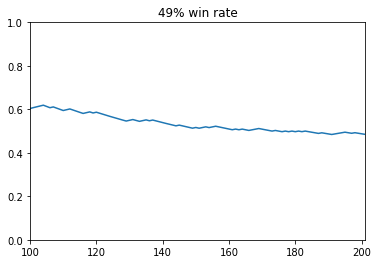

In [85]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

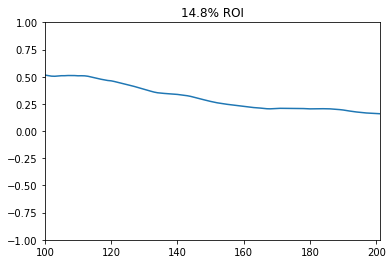

In [86]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(10).mean().plot(title=roi_title, xlim=(100), ylim=(-1, 1))

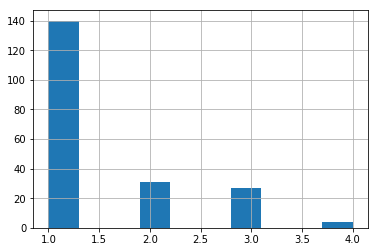

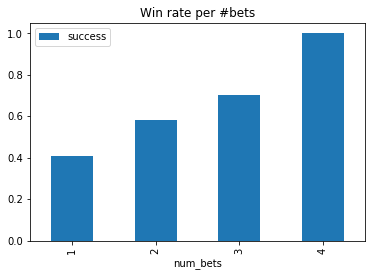

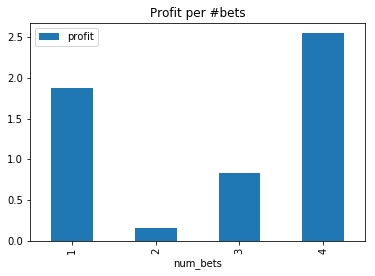

In [87]:
# profit per num bets 
df.num_bets.hist()
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

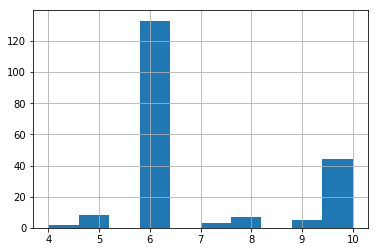

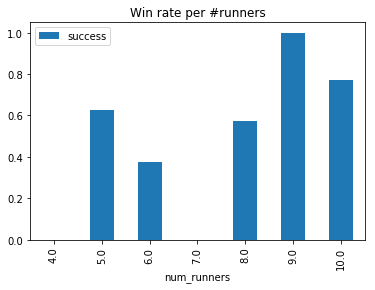

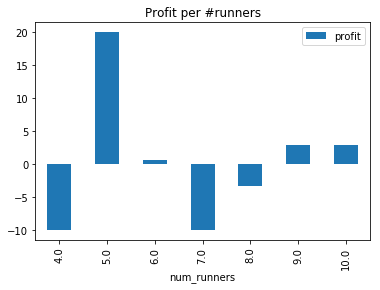

In [88]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

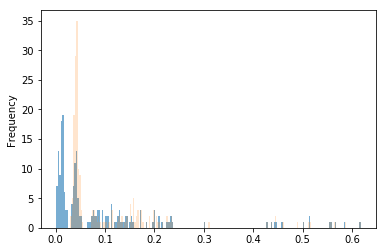

In [89]:
# max diff
df.win_diff.plot(kind='hist', bins=200, alpha=0.6)
df.max_diff.plot(kind='hist', bins=200, alpha=0.2)

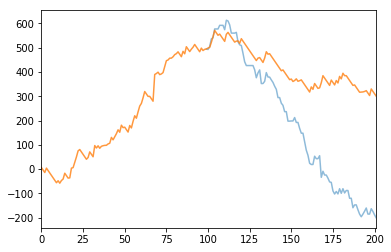

In [90]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.5)
df.profit.cumsum().plot(alpha=0.8)

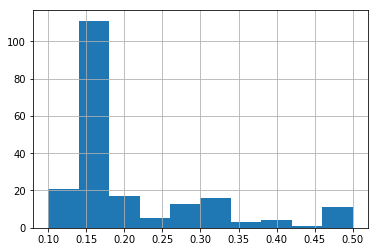

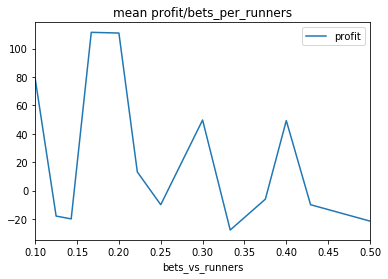

In [91]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

In [92]:
# # pred vs scale
# df['prob_vs_scale'] = df.pr / df.num_runners
# df['bets_vs_runners'].hist(bins=10)
# groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
# groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

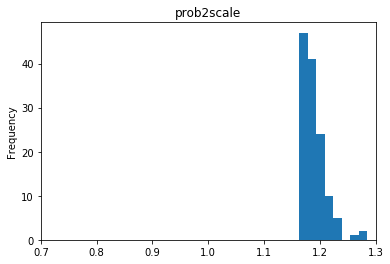

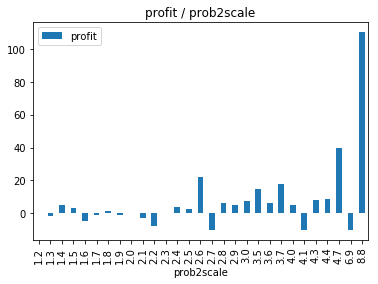

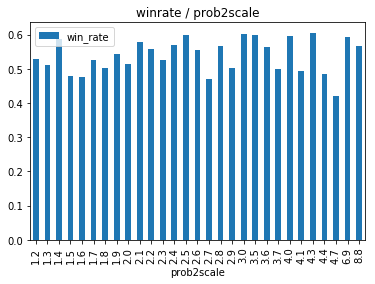

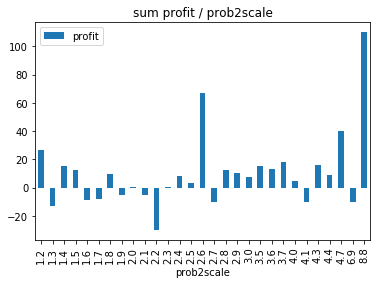

In [93]:
df.prob2scale.plot(kind='hist', bins=500, xlim=(.7, 1.3), title='prob2scale')
groups = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='profit / prob2scale')
groups.plot(kind='bar', y='win_rate', title='winrate / prob2scale')

groups_sum = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).sum()
groups_sum.plot(kind='bar', y='profit', title='sum profit / prob2scale')